Ce notebook a été entièrement réalisé par Mélnaie Gomis.

In [1]:
import numpy as np
import glob
import sys
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import gdown
import matplotlib.pyplot as plt

# Chargement des données

In [3]:
# On définit le nom du dossier
dossier_nom = "redshift"
url = "https://drive.google.com/drive/folders/1-tQH6rfB1XoF7ml98yqVn7Z2IQwGMUdK"

# 2. LOGIQUE DE TÉLÉCHARGEMENT
if os.path.exists(dossier_nom):
    print(f"✅ Le dossier '{dossier_nom}' est déjà présent. Pas besoin de retélécharger !")
else:
    print(f"📥 Dossier introuvable. Téléchargement en cours...")
    gdown.download_folder(url, quiet=True, use_cookies=False)
    print("✅ Téléchargement terminé !")

# 3. CRÉATION DE LA LISTE DES FICHIERS (C'est ici que ça plantait avant)
# On scanne le dossier pour créer la liste 'dossier_local' quoi qu'il arrive
pattern = os.path.join(dossier_nom, "*.npz") # ex: redshift/*
dossier_local = glob.glob(pattern)

# 4. AFFICHAGE JOLI
print(f"\nSuccès ! {len(dossier_local)} fichiers trouvés dans '{dossier_nom}'.")
print("Détail des fichiers :")

for chemin in dossier_local:
    # On extrait le nom du dossier et le nom du fichier
    dossier = os.path.dirname(chemin)   # ex: redshift
    fichier = os.path.basename(chemin)  # ex: COSMOS_...npz
    
    # Ton format demandé
    print(f"[{dossier}] :\t {fichier}")

✅ Le dossier 'redshift' est déjà présent. Pas besoin de retélécharger !

Succès ! 6 fichiers trouvés dans 'redshift'.
Détail des fichiers :
[redshift] :	 COSMOS_v11_uijk_0213_photo_UD.npz
[redshift] :	 COSMOS_v11_uijk_0020_spec_D.npz
[redshift] :	 COSMOS_v11_uijk_0073_spec_UD.npz
[redshift] :	 COSMOS_v11_uijk_0001_photo_D.npz
[redshift] :	 XMM_LSS_v11_uijk_0162_phot_D.npz
[redshift] :	 XMM_LSS_v11_uijk_0006_spec_D.npz


In [4]:
fichiers_npz = glob.glob('redshift/*.npz')
cosmos_files = [f for f in fichiers_npz if "COSMOS" in f]

# Listes séparées pour train et test
train_cubes_list = []
train_infos_list = []
train_flag_list = []

test_cubes_list = []
test_infos_list = []
test_flag_list = []

print(f"Chargement de {len(cosmos_files)} fichiers COSMOS.")

for fichier in cosmos_files:
    try:
        data = np.load(fichier, allow_pickle=True)
        
        # 'info' est un array structuré. 'dtype.names' donne les noms des colonnes.
        info_fields = data['info'].dtype.names
        
        # On vérifie si la *colonne* 'ZSPEC' existe dans ce fichier
        if 'ZSPEC' in info_fields:
            # Ce fichier contient des données de TEST (il a la colonne ZSPEC)
            test_cubes_list.append(data['cube'])
            test_infos_list.append(data['info'])
            test_flag_list.append(data['flag'])
        else:
            # Ce fichier contient des données de TRAIN (pas de colonne ZSPEC)
            train_cubes_list.append(data['cube'])
            train_infos_list.append(data['info'])
            train_flag_list.append(data['flag'])
            
            
    except Exception as e:
        print(f":x: Erreur en chargeant {fichier}: {e}")

print("Chargement terminé.")

Chargement de 4 fichiers COSMOS.
Chargement terminé.


In [5]:
# Création des jeux train/test

# Jeu d’entraînement (basé sur les fichiers SANS ZSPEC)
# On vérifie qu'on a bien trouvé des fichiers de train
if train_infos_list:
    X_train = np.concatenate(train_cubes_list, axis=0)
    infos_train = np.concatenate(train_infos_list, axis=0)
    flags_train = np.concatenate(train_flag_list, axis=0)
    y_train = infos_train['ZPHOT'] # Obtenir ZPHOT depuis les infos de train
    print(f"Objets d'entraînement (ZPHOT) : {len(y_train)}")
    print("X_train :", X_train.shape)
    print("y_train :", y_train.shape)
else:
    print("Aucun fichier d'entraînement (sans ZSPEC) trouvé.")

print("\n---\n")

# Jeu de test (basé sur les fichiers AVEC ZSPEC)
# On vérifie qu'on a bien trouvé des fichiers de test
if test_infos_list:
    X_test = np.concatenate(test_cubes_list, axis=0)
    infos_test = np.concatenate(test_infos_list, axis=0)
    flags_test = np.concatenate(test_flag_list, axis=0)
    y_test = infos_test['ZSPEC'] # Obtenir ZSPEC depuis les infos de test

    # Si on ne garde que les ZSPEC valides
    # mask_zspec_valid = ~np.isnan(y_test) ou ???
    # X_test = X_test[mask_zspec_valid]
    # y_test = y_test[mask_zspec_valid]

    print(f"Objets de test (ZSPEC) : {len(y_test)}")
    print("X_test  :", X_test.shape)
    print("y_test  :", y_test.shape)
else:
    print("Aucun fichier de test (avec ZSPEC) trouvé.")

Objets d'entraînement (ZPHOT) : 12497
X_train : (12497, 64, 64, 9)
y_train : (12497,)

---

Objets de test (ZSPEC) : 27
X_test  : (27, 64, 64, 9)
y_test  : (27,)


# Chargement des codes python

In [6]:
# 1️⃣ Nom du dossier local
dossier_nom = "redshift/Marie Treyer"

# 2️⃣ ID du dossier Google Drive
folder_id = "1mqIUBkZ3qN82hQ3H5WEdz0YYggMxZe3J"

# 3️⃣ Téléchargement si nécessaire
if os.path.exists(dossier_nom):
    print(f"✅ Le dossier '{dossier_nom}' est déjà présent. Pas besoin de retélécharger !")
else:
    print(f"📥 Dossier introuvable. Téléchargement en cours...")
    try:
        gdown.download_folder(
            id=folder_id,       # utilisation de l'ID
            output=dossier_nom,
            quiet=False,
            use_cookies=False
        )
        print("✅ Téléchargement terminé !")
    except Exception as e:
        print("⚠️ Impossible de télécharger le dossier avec gdown.")
        print("Essayez de le télécharger manuellement depuis le navigateur.")
        raise e

# 4️⃣ Recherche récursive de tous les fichiers .py
pattern = os.path.join(dossier_nom, "**", "*.py")
fichiers_py = glob.glob(pattern, recursive=True)

# 5️⃣ Affichage
print(f"\nSuccès ! {len(fichiers_py)} fichiers .py trouvés dans '{dossier_nom}'.\n")
for chemin in fichiers_py:
    dossier = os.path.dirname(chemin)
    fichier = os.path.basename(chemin)
    print(f"[{dossier}] :\t {fichier}")


✅ Le dossier 'redshift/Marie Treyer' est déjà présent. Pas besoin de retélécharger !

Succès ! 3 fichiers .py trouvés dans 'redshift/Marie Treyer'.

[redshift/Marie Treyer] :	 model_multi_modal_simple.py
[redshift/Marie Treyer] :	 models_building_blocks.py
[redshift/Marie Treyer/utils] :	 config.py


In [7]:
# Chemin absolu du dossier contenant les modules
dossier_nom = "redshift/Marie Treyer"
chemin_absolu = os.path.abspath(dossier_nom)

if chemin_absolu not in sys.path:
    sys.path.append(chemin_absolu)

# Maintenant l'import devrait fonctionner
from model_multi_modal_simple import *

# Création du modèles

In [8]:
import torch
import numpy as np
from model_multi_modal_simple import Model_multi_modal_simple
import utils.config as config

# 1. Préparation des tenseurs
X_train_tensor = torch.tensor(np.transpose(X_train, (0, 3, 1, 2)).copy(), dtype=torch.float32)
X_test_tensor = torch.tensor(np.transpose(X_test, (0, 3, 1, 2)).copy(), dtype=torch.float32)

y_train_tensor = torch.tensor(y_train.copy(), dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test.copy(), dtype=torch.float32).unsqueeze(1)

# 2. Instanciation du modèle
modalities = [list(range(9))]

model = Model_multi_modal_simple(
    in_dim=[64, 64],
    n_outputs=1, 
    modalities=modalities,
    mags_input_size=None, 
    parallel_before_inception_archi=[32, 32],
    parallel_inception_archi=[36, 32, 32, 32, 42, 42], 
    parallel_pooling_before_inceptions=[True, False, False, False, False, False], 
    inception_archi=[109, 101, 101, 101, 156, 156], 
    pooling_before_inceptions=[False, True, False, True, False, False] 
)

device = torch.device(config.CONFIG["DEVICE"])
model.to(device)
model.eval()

# 3. Lancement du Forward Pass (avec le correctif)
print("\n-- Lancement de la prédiction --")
with torch.no_grad(): 
    batch_X = X_test_tensor[:5].to(device)
    
    # CORRECTIF : Création d'un tenseur "ebv" factice (des zéros) de la même taille que le batch
    # Cela permet de contourner le bug d'aplatissement et comble le "+1" attendu par la couche FC
    dummy_ebv = torch.zeros(batch_X.size(0)).to(device)
    
    # On passe notre variable dummy_ebv au modèle
    out_classif, out_regress = model(batch_X, ebv=dummy_ebv)
    
    print(f"Dimension sortie Régression : {out_regress.shape}")
    print(f"Valeurs prédites par le modèle (non entraîné) :\n{out_regress.cpu().numpy()}")

self.in_dim [64, 64]
self.modalities 1

-- Lancement de la prédiction --
Dimension sortie Régression : torch.Size([5, 1])
Valeurs prédites par le modèle (non entraîné) :
[[0.10198963]
 [0.10075758]
 [0.10172486]
 [0.10149205]
 [0.10166621]]


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import utils.config as config

# --- CORRECTIF DROPOUT ---
# On désactive le dropout de modalité puisqu'on a regroupé les 9 canaux dans 1 seule modalité
config.CONFIG["MODALITY_DROP_OUT"] = None

# 1. Création du jeu de données et du DataLoader
print("-- Préparation des données d'entraînement --")
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)

train_loader = DataLoader(
    train_dataset, 
    batch_size=config.CONFIG["BATCH_SIZE"], 
    shuffle=True, 
    num_workers=config.CONFIG.get("NUM_WORKERS", 0), 
    pin_memory=config.CONFIG.get("PIN_MEMORY", False) 
)

# 2. Définition de la fonction de Perte et de l'Optimiseur
criterion = nn.MSELoss() 
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 3. Paramètres de la boucle d'entraînement
epochs = 10 
device = torch.device(config.CONFIG["DEVICE"]) 

print(f"\n-- Début de l'entraînement sur {device} --")

-- Préparation des données d'entraînement --

-- Début de l'entraînement sur cuda --


In [10]:
for epoch in range(epochs):
    # Mode entraînement (active les Batch Norms)
    model.train() 
    
    running_loss = 0.0
    
    for batch_idx, (batch_X, batch_y) in enumerate(train_loader):
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)
        
        # Faux tenseur ebv (zéro) pour ce batch spécifique
        dummy_ebv = torch.zeros(batch_X.size(0)).to(device)
        
        # Étape 1 : Réinitialiser les gradients
        optimizer.zero_grad()
        
        # Étape 2 : Prédiction
        out_classif, out_regress = model(batch_X, ebv=dummy_ebv)
        
        # Étape 3 : Calcul de l'erreur
        loss = criterion(out_regress, batch_y)
        
        # Étape 4 : Rétropropagation
        loss.backward()
        
        # Étape 5 : Mise à jour des poids
        optimizer.step()
        
        # Statistiques
        running_loss += loss.item()
        
        # Affichage régulier
        if (batch_idx + 1) % 1 == 0:
            print(f"Époque [{epoch+1}/{epochs}], Batch [{batch_idx+1}/{len(train_loader)}], Perte (MSE): {running_loss/100:.4f}")
            running_loss = 0.0
            
    print(f"==> Fin de l'époque {epoch+1} terminée. <==")

Époque [1/10], Batch [1/391], Perte (MSE): 0.0375
Époque [1/10], Batch [2/391], Perte (MSE): 0.0390
Époque [1/10], Batch [3/391], Perte (MSE): 0.0144
Époque [1/10], Batch [4/391], Perte (MSE): 0.0065
Époque [1/10], Batch [5/391], Perte (MSE): 0.0132
Époque [1/10], Batch [6/391], Perte (MSE): 0.0092
Époque [1/10], Batch [7/391], Perte (MSE): 0.0135
Époque [1/10], Batch [8/391], Perte (MSE): 0.0084
Époque [1/10], Batch [9/391], Perte (MSE): 0.0073
Époque [1/10], Batch [10/391], Perte (MSE): 0.0057
Époque [1/10], Batch [11/391], Perte (MSE): 0.0091
Époque [1/10], Batch [12/391], Perte (MSE): 0.0065
Époque [1/10], Batch [13/391], Perte (MSE): 0.0104
Époque [1/10], Batch [14/391], Perte (MSE): 0.0141
Époque [1/10], Batch [15/391], Perte (MSE): 0.0081
Époque [1/10], Batch [16/391], Perte (MSE): 0.0064
Époque [1/10], Batch [17/391], Perte (MSE): 0.0110
Époque [1/10], Batch [18/391], Perte (MSE): 0.0057
Époque [1/10], Batch [19/391], Perte (MSE): 0.0058
Époque [1/10], Batch [20/391], Perte (MS

-- Début de l'entraînement sur cuda avec suivi des pertes --
Époque [1/10] | Train Loss: 0.4042 | Test Loss: 3.7242
Époque [2/10] | Train Loss: 0.3970 | Test Loss: 3.2570
Époque [3/10] | Train Loss: 0.3862 | Test Loss: 3.1360
Époque [4/10] | Train Loss: 0.3766 | Test Loss: 2.8148
Époque [5/10] | Train Loss: 0.3673 | Test Loss: 5.9915
Époque [6/10] | Train Loss: 0.3668 | Test Loss: 2.2677
Époque [7/10] | Train Loss: 0.3539 | Test Loss: 2.0263
Époque [8/10] | Train Loss: 0.3428 | Test Loss: 3.5937
Époque [9/10] | Train Loss: 0.3444 | Test Loss: 3.1619
Époque [10/10] | Train Loss: 0.3304 | Test Loss: 2.8657


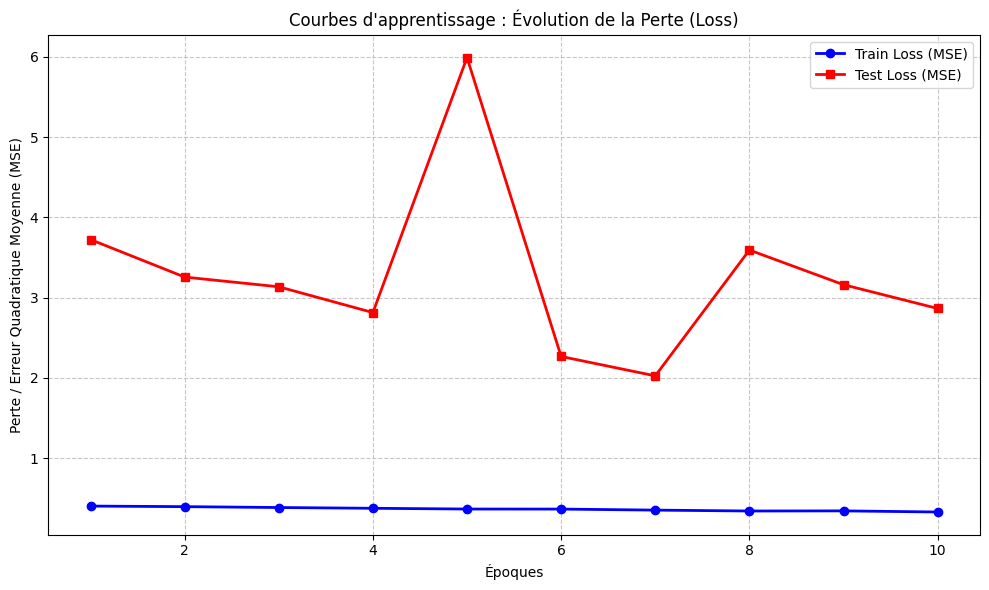

In [12]:
import matplotlib.pyplot as plt
import torch

# 1. Initialisation des listes pour stocker l'historique
train_losses = []
test_losses = []

epochs = 10 # À ajuster selon vos besoins

print(f"-- Début de l'entraînement sur {device} avec suivi des pertes --")

for epoch in range(epochs):
    # ==========================
    # PHASE D'ENTRAÎNEMENT
    # ==========================
    model.train() 
    running_train_loss = 0.0
    
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        dummy_ebv = torch.zeros(batch_X.size(0)).to(device)
        
        optimizer.zero_grad()
        _, out_regress = model(batch_X, ebv=dummy_ebv)
        loss = criterion(out_regress, batch_y)
        loss.backward()
        optimizer.step()
        
        # On multiplie par la taille du batch pour avoir une moyenne exacte à la fin
        running_train_loss += loss.item() * batch_X.size(0)
        
    # Calcul de la perte moyenne pour cette époque (Train)
    epoch_train_loss = running_train_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)
    
    # ==========================
    # PHASE DE TEST (VALIDATION)
    # ==========================
    model.eval() # Important : on désactive le dropout pour évaluer
    
    with torch.no_grad():
        # Comme le jeu de test est petit (27 objets), on l'évalue en une seule passe
        batch_X_test = X_test_tensor.to(device)
        batch_y_test = y_test_tensor.to(device)
        dummy_ebv_test = torch.zeros(batch_X_test.size(0)).to(device)
        
        _, out_regress_test = model(batch_X_test, ebv=dummy_ebv_test)
        test_loss = criterion(out_regress_test, batch_y_test)
        
        # On sauvegarde la perte de test
        epoch_test_loss = test_loss.item()
        test_losses.append(epoch_test_loss)
        
    print(f"Époque [{epoch+1}/{epochs}] | Train Loss: {epoch_train_loss:.4f} | Test Loss: {epoch_test_loss:.4f}")

# 2. Affichage des courbes de perte avec Matplotlib
plt.figure(figsize=(10, 6))

# Tracé de la courbe d'entraînement (en bleu)
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss (MSE)', marker='o', color='blue', linewidth=2)

# Tracé de la courbe de test (en rouge)
plt.plot(range(1, epochs + 1), test_losses, label='Test Loss (MSE)', marker='s', color='red', linewidth=2)

# Mise en forme du graphique
plt.title("Courbes d'apprentissage : Évolution de la Perte (Loss)")
plt.xlabel("Époques")
plt.ylabel("Perte / Erreur Quadratique Moyenne (MSE)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

# Affichage
plt.tight_layout()
plt.show()

In [13]:
import numpy as np
import torch

# 1. Passer le modèle en mode évaluation (Désactive le Dropout et fige les BatchNorm)
model.eval()

print("-- Lancement de l'évaluation sur le jeu de test --")
with torch.no_grad():
    # Comme X_test_tensor ne contient que 27 objets, on peut le passer en un seul batch
    batch_X = X_test_tensor.to(device)
    batch_y = y_test_tensor.to(device)
    
    # Correctif : Faux tenseur ebv (zéro) pour le forward pass
    dummy_ebv = torch.zeros(batch_X.size(0)).to(device)
    
    # Prédictions
    _, out_regress = model(batch_X, ebv=dummy_ebv)
    
    # Récupération sur CPU et conversion en tableaux numpy 1D
    z_phot = out_regress.cpu().numpy().flatten()
    z_spec = batch_y.cpu().numpy().flatten()

# 2. Calcul des métriques
# Différence absolue normalisée
delta_z = z_phot - z_spec
norm_abs_delta_z = np.abs(delta_z) / (1 + z_spec)

# Calcul du Sigma_NMAD
sigma_nmad = 1.4826 * np.median(norm_abs_delta_z)

# Calcul du biais (médiane de l'erreur directionnelle)
bias = np.median(delta_z / (1 + z_spec))

# Calcul de la fraction d'outliers (seuil classique > 0.15)
outlier_fraction = np.mean(norm_abs_delta_z > 0.15) * 100 

# 3. Affichage des résultats
print(f"Nombre d'objets évalués : {len(z_spec)}")
print(f"Sigma_NMAD : {sigma_nmad:.4f}")
print(f"Biais médian : {bias:.4f}")
print(f"Fraction d'outliers (|Δz|/(1+z) > 0.15) : {outlier_fraction:.2f}%")

# Optionnel : Afficher les 5 premières prédictions pour vérifier visuellement
print("\n-- Aperçu des prédictions --")
for i in range(min(5, len(z_spec))):
    print(f"Objet {i+1} | Z_SPEC: {z_spec[i]:.4f} | Z_PHOT (prédit): {z_phot[i]:.4f}")

-- Lancement de l'évaluation sur le jeu de test --
Nombre d'objets évalués : 27
Sigma_NMAD : 0.7417
Biais médian : 0.1542
Fraction d'outliers (|Δz|/(1+z) > 0.15) : 66.67%

-- Aperçu des prédictions --
Objet 1 | Z_SPEC: 0.4949 | Z_PHOT (prédit): 0.5509
Objet 2 | Z_SPEC: 0.0331 | Z_PHOT (prédit): 1.0023
Objet 3 | Z_SPEC: 0.7186 | Z_PHOT (prédit): 2.6720
Objet 4 | Z_SPEC: 0.0522 | Z_PHOT (prédit): 1.5157
Objet 5 | Z_SPEC: 0.6187 | Z_PHOT (prédit): 0.5714
